# Compare the reconstruction training losses of keras CAE to tf model

0. Common

In [4]:
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

encoder = keras.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=16)
])

decoder = keras.Sequential([
    keras.layers.Input(shape=(16)),
    keras.layers.Dense(7*7*64),
    keras.layers.Reshape((7, 7, 64)),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
    keras.layers.Activation('sigmoid')
])

1. Keras model

Epoch 1/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0223 - val_loss: 0.0108
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 3/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 7/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 9/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0

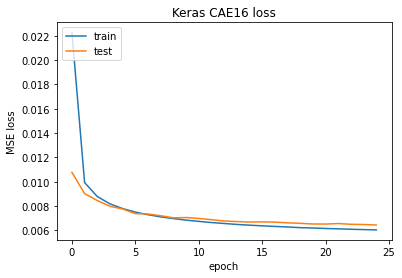

In [6]:
import keras

model = keras.models.Model(encoder.inputs, decoder(encoder(encoder.inputs)))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, x_train, validation_data=(x_test, x_test), batch_size=32, verbose=True, epochs=25)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CAE16 loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2. TF model

Epoch  1 || train loss: 0.02209 | test loss: 0.01064 | time: 12.5s
Epoch  2 || train loss: 0.00976 | test loss: 0.00903 | time: 12.1s
Epoch  3 || train loss: 0.00868 | test loss: 0.00849 | time: 11.3s
Epoch  4 || train loss: 0.00812 | test loss: 0.00805 | time: 11.1s
Epoch  5 || train loss: 0.00776 | test loss: 0.00787 | time: 12.5s
Epoch  6 || train loss: 0.00750 | test loss: 0.00754 | time: 13.4s
Epoch  7 || train loss: 0.00729 | test loss: 0.00733 | time: 13.0s
Epoch  8 || train loss: 0.00712 | test loss: 0.00722 | time: 13.0s
Epoch  9 || train loss: 0.00699 | test loss: 0.00717 | time: 11.3s
Epoch 10 || train loss: 0.00687 | test loss: 0.00711 | time: 11.3s
Epoch 11 || train loss: 0.00677 | test loss: 0.00702 | time: 13.2s
Epoch 12 || train loss: 0.00669 | test loss: 0.00693 | time: 11.9s
Epoch 13 || train loss: 0.00660 | test loss: 0.00691 | time: 11.6s
Epoch 14 || train loss: 0.00654 | test loss: 0.00690 | time: 9.9s
Epoch 15 || train loss: 0.00648 | test loss: 0.00681 | time: 10

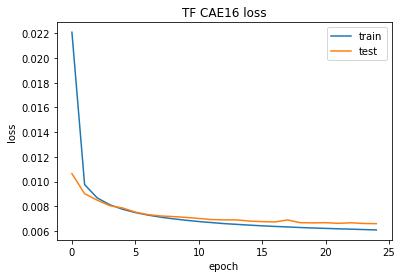

In [5]:
import keras
import tensorflow as tf

class tf_model(keras.models.Model):
    def __init__(self):
        super(tf_model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.compile()
    def encode(self, x):
        return self.encoder(x)
    def decode(self, z):
        return self.decoder(z)
    def mse_loss(self, x):
        z = self.encode(x)
        x_pred = self.decode(z)
        err = tf.reduce_mean(tf.square(tf.subtract(x_pred, x)))
        return err
    
@tf.function
def train_step(model, optimizer, x):
    with tf.GradientTape() as tape:
        loss = model.mse_loss(x)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

x_train_tf = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1024).batch(32)
x_test_tf = tf.data.Dataset.from_tensor_slices(x_test).shuffle(buffer_size=1024).batch(32)
optimizer = keras.optimizers.Adam()
model = tf_model()

import time
train_losses, test_losses = [], []
for epoch in range(1, 26):
    start_time = time.time()
    
    # Train
    train_loss = keras.metrics.Mean()
    for i, (x) in enumerate(x_train_tf):
        train_loss(train_step(model, optimizer, x))
    train_losses.append(train_loss.result())
     
    # Test
    test_loss = keras.metrics.Mean()
    for i, (x) in enumerate(x_test_tf):
        test_loss(model.mse_loss(x))
    test_losses.append(test_loss.result())
    
    end_time = time.time()
    delta = round(end_time - start_time, 1)
    print("Epoch {:2d} || train loss: {:.5f} | test loss: {:.5f} | time: {}s".format(epoch, train_losses[epoch-1], test_losses[epoch-1], delta))

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('TF CAE16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [6]:
model.encoder.save_weights('../weights/16_CE16_epoch25.h5')